# Tutorial 1: 10X Visium

In this tutorial, we show how to apply DeepST to identify spatial domains on 10X Visium data. As a example, we analyse the 151673 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

We derived the preprocessed data from the spatialLIBD package, including manual annotations. Before running the model, please download the input data via https://drive.google.com/drive/folders/1DocCbwz5_ADyO_lnarjAIi1KKLSqtizB.

# Loading package

In [21]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [22]:
from DeepST import DeepST

In [23]:
# Run device
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [24]:
# the number of clusters
n_clusters = 7

In [25]:
dataset = '151673'

# Reading ST data

The necessary input files includes:
1) The gene expression matrix: filtered_feature_bc_matrix.h5;
2) Spatial coordinates: position.txt;
3) Histology image: the format should be .png.    
    
In the example, position inforamtion has been saved in adata.obsm['spatial']. To make the model can read the data sucessfully, 
please ensure the same format input file as example.

In [26]:
# read data
file_fold = '/home/yahui/Yahui/Projects/data/' + str(dataset) #please replace it with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Training the model

DeepST model aims to learn refined representations for spots by making full use of gene expressions and spatial location information in a contrastive learning way.
After model training, the learned representations will be saved in adata.obsm and used for next spatial clustering. 

In [27]:
# define and train model
model = DeepST.DeepST(adata, device=device)
adata = model.train_DeepST()

Begin to train ST data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 88.28it/s]


Optimization finished for ST data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 83.41it/s]


In [28]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'emb', 'emb_reg'

# Spatial clustering and refinement

In the clustering result, some spots may be wrongly assigned to spatially disparate domains. 
We consider such occurrences to be noise and their presence may influence downstream biological analysis. 
Therefore, we extend our DeepST model with an optional optimization step to remove the noises. In short, for a given spot,
its lable will be re-assigned as the same domain as the most common lable of its surronding spots (please refer to the manuscript for more details).
To do so, parameter 'radius' is set to specify the number of neighbors.

Please note that this step is not recommended for ST data with fine-grained domains (e.g., mouse brain anterior and posterior), Stereo-seq, and Slide-seqV2.
In this study, we only applied this refinement step to the human brain DLPFC and the human breast cancer dataset.

In [29]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

# clustering
from DeepST.utils import clustering
clustering(adata, n_clusters, radius=radius, refinement=True) #For DLPFC dataset, we use optional refinement step.

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


# Visualization

For DLPFC data, the original authors manually annotated the slices. The annotation for 151673 slice can be downloaded from https://drive.google.com/drive/folders/1DocCbwz5_ADyO_lnarjAIi1KKLSqtizB. 
For quantitative assessment, we use well-known ARI metric to evaulate the performance. 
Since not all of spots were annotated, we filtered out NA nodes before the ARI calculate and visualization. 

In [30]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [31]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])] 
        
# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
    
print('Dataset:', dataset)
print('ARI:', ARI)

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151673
ARI: 0.6204171832786775


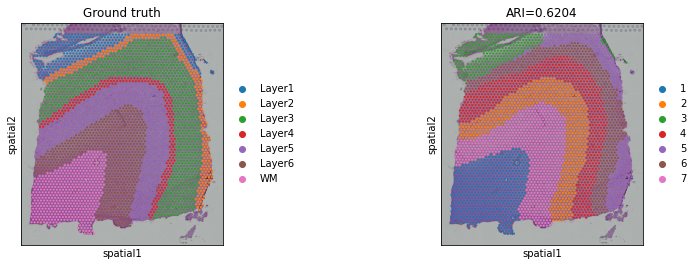

In [32]:
# plotting spatial clustering result
sc.pl.spatial(adata, 
              img_key="hires", 
              color=["ground_truth", "domain"], 
              title=["Ground truth", "ARI=%.4f"%ARI], 
              show=True)

The learned representations will be incluced in adata.obsm['emb'] or adata.obsm['emb_pca'] (PCA dimension reduction), which can be used for UMAP visualization.

<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

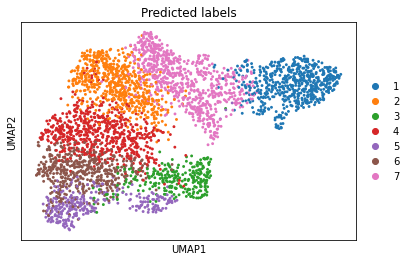

In [33]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)